In [164]:
import torch
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import os

In [165]:
path = os.getcwd()+'\Joint_Dataset.csv'

In [166]:
dataset = pd.read_csv(path)
dataset.head()

,left_shoulder_X,left_shoulder_Y,left_shoulder_Z,left_elbow_X,left_elbow_Y,left_elbow_Z,left_wrist_X,left_wrist_Y,left_wrist_Z,left_hand_X,...,right_knee_X,right_knee_Y,right_knee_Z,right_ankle_X,right_ankle_Y,right_ankle_Z,right_foot_X,right_foot_Y,right_foot_Z,label
0,120.0,80.0,-269.0,114.0,108.0,-267.0,116.0,139.0,-255.0,115.0,...,153.0,182.0,-276.0,154.0,225.0,-285.0,153.0,234.0,-243.0,1
1,121.0,81.0,-268.0,114.0,109.0,-266.0,115.0,140.0,-255.0,117.0,...,153.0,182.0,-276.0,154.0,226.0,-284.0,154.0,234.0,-242.0,1
2,120.0,81.0,-269.0,114.0,109.0,-266.0,115.0,140.0,-257.0,117.0,...,153.0,182.0,-276.0,155.0,226.0,-283.0,155.0,234.0,-241.0,1
3,120.0,81.0,-269.0,113.0,109.0,-266.0,115.0,140.0,-255.0,116.0,...,153.0,182.0,-275.0,154.0,225.0,-286.0,154.0,234.0,-244.0,1
4,120.0,81.0,-269.0,114.0,109.0,-267.0,115.0,140.0,-255.0,117.0,...,153.0,182.0,-275.0,154.0,225.0,-285.0,154.0,234.0,-243.0,1


In [167]:
X = dataset.drop('label',axis=1)
y = dataset['label']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [169]:
trainset = pd.concat([X_train,y_train],axis=1)
testset = pd.concat([X_test,y_test],axis=1)

In [170]:
class MSRDataset(Dataset):
    def __init__(self,data):
        self.len = data.shape[0]
        self.x_data = torch.from_numpy(data.drop('label',axis=1).to_numpy()).float()
        self.y_data = torch.from_numpy(data['label'].to_numpy()-1).type(torch.LongTensor)
    
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.len

In [171]:
train_data = MSRDataset(trainset)
test_data = MSRDataset(testset)

In [172]:
trainloader = DataLoader(dataset=train_data,batch_size=32,shuffle=True,num_workers=0)
testloader = DataLoader(dataset=test_data,batch_size=32,shuffle=True,num_workers=0)

In [173]:
import pdb

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        #h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        out, hn = self.lstm(x, None)
        out = self.fc(out[:, -1, :]) 
        return out

In [174]:
# Hidden layer dimension
N_s = trainset.shape[0] #Nₛ the number of samples in the training data
alpha = 2 # α represents a scaling factor that is usually between 2 and 10
# Create RNN
input_dim = 60    # input dimension Nᵢ is the number of input neurons
layer_dim = 2     # number of hidden layers
output_dim = 20   # output dimension Nₒ the number of output neurons
hidden_dim = int(N_s/(alpha* (input_dim+output_dim)))  # hidden layer dimension

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
print(model)

LSTMModel(
  (lstm): LSTM(60, 95, num_layers=2, batch_first=True)
  (fc): Linear(in_features=95, out_features=20, bias=True)
)


In [175]:
criterion = nn.CrossEntropyLoss()
# SGD Optimizer
#learning_rate = 0.05
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [176]:
# batch_size, epoch and iteration
batch_size = 64
n_iters = 8000
num_epochs = n_iters / (N_s / batch_size)
num_epochs = int(num_epochs)
num_epochs

33

In [177]:
loss_list = []
ite_list = []
accuracy_list = []
count=0
for epoch in range(num_epochs):
    for i,data in enumerate(trainloader):
        inputs,labels = data
        inputs,labels = Variable(inputs.view(-1,1,60)),Variable(labels)
        #pdb.set_trace()
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        count+=1
        #print("iteration",count)
        if count %250 == 0:
            correct = 0
            total = 0
            loss_list.append(loss.data)
            ite_list.append(count)
            with torch.no_grad():
                for data in testloader:
                    inputs,labels = data
                    inputs,labels = Variable(inputs.view(-1,1,60)),Variable(labels)
                    output = model(inputs)
                    for idx, i in enumerate(output):
                        #pdb.set_trace()
                        if torch.argmax(i) == labels[idx]:
                            correct+=1
                        total+=1
            accuracy_list.append(round(correct/total,3)*100)
            if count % 500 == 0:
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, round(correct/total,3)*100))
        

Iteration: 500  Loss: 2.8829972743988037  Accuracy: 10.5 %
Iteration: 1000  Loss: 2.7963855266571045  Accuracy: 10.100000000000001 %
Iteration: 1500  Loss: 2.9495837688446045  Accuracy: 8.7 %
Iteration: 2000  Loss: 2.8169116973876953  Accuracy: 9.8 %
Iteration: 2500  Loss: 2.7236976623535156  Accuracy: 10.299999999999999 %
Iteration: 3000  Loss: 2.722324848175049  Accuracy: 10.8 %
Iteration: 3500  Loss: 2.4413082599639893  Accuracy: 11.0 %
Iteration: 4000  Loss: 2.985496759414673  Accuracy: 11.0 %
Iteration: 4500  Loss: 2.9306368827819824  Accuracy: 10.100000000000001 %
Iteration: 5000  Loss: 2.7470409870147705  Accuracy: 9.6 %
Iteration: 5500  Loss: 2.779970407485962  Accuracy: 9.2 %
Iteration: 6000  Loss: 2.8113152980804443  Accuracy: 9.9 %
Iteration: 6500  Loss: 2.7034707069396973  Accuracy: 10.7 %
Iteration: 7000  Loss: 2.7636148929595947  Accuracy: 10.7 %
Iteration: 7500  Loss: 2.8208398818969727  Accuracy: 11.200000000000001 %
Iteration: 8000  Loss: 2.58072829246521  Accuracy: 10

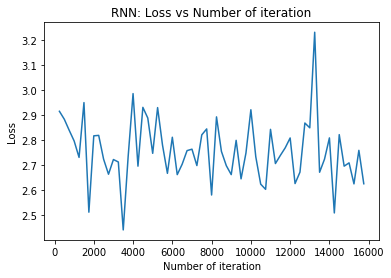

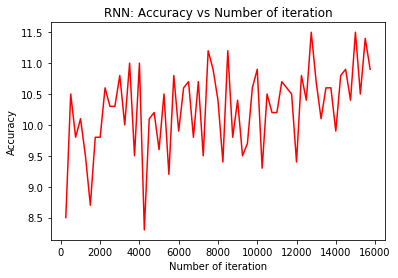

In [178]:
# visualization loss 
plt.plot(ite_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(ite_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
#plt.savefig('graph.png')
plt.show()